In [6]:
import theano
import lasagne
import numpy as np

import theano.tensor as T
from numpy import random as rnd, linalg as la

from layers import UnitaryLayer, RecurrentUnitaryLayer
from matplotlib import pyplot as plt
from utils.optimizations import nesterov_momentum, custom_sgd

np.set_printoptions(linewidth=200, suppress=True)

import seaborn as sns

sns.set_style('white')

%matplotlib inline

WARNING (theano.configdefaults): Only clang++ is supported. With g++, we end up with strange g++/OSX bugs.
/Users/cnst/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
# Min/max sequence length
MIN_LENGTH = 50
MAX_LENGTH = 55
# Number of units in the hidden (recurrent) layer
N_HIDDEN = 100
# Number of training sequences in each batch
N_BATCH = 100
# Optimization learning rate
LEARNING_RATE = .001
# All gradients above this will be clipped
GRAD_CLIP = 100
# How often should we check the output?
EPOCH_SIZE = 100
# Number of epochs to train the net
NUM_EPOCHS = 100
# Exact sequence length
TIME_SEQUENCES=100

In [4]:
def gen_data(min_length=MIN_LENGTH, max_length=MAX_LENGTH, n_batch=N_BATCH):
    '''
    Generate a batch of sequences for the "add" task, e.g. the target for the
    following

    ``| 0.5 | 0.7 | 0.3 | 0.1 | 0.2 | ... | 0.5 | 0.9 | ... | 0.8 | 0.2 |
      |  0  |  0  |  1  |  0  |  0  |     |  0  |  1  |     |  0  |  0  |``

    would be 0.3 + .9 = 1.2.  This task was proposed in [1]_ and explored in
    e.g. [2]_.

    Parameters
    ----------
    min_length : int
        Minimum sequence length.
    max_length : int
        Maximum sequence length.
    n_batch : int
        Number of samples in the batch.

    Returns
    -------
    X : np.ndarray
        Input to the network, of shape (n_batch, max_length, 2), where the last
        dimension corresponds to the two sequences shown above.
    y : np.ndarray
        Correct output for each sample, shape (n_batch,).
    mask : np.ndarray
        A binary matrix of shape (n_batch, max_length) where ``mask[i, j] = 1``
        when ``j <= (length of sequence i)`` and ``mask[i, j] = 0`` when ``j >
        (length of sequence i)``.

    References
    ----------
    .. [1] Hochreiter, Sepp, and Jürgen Schmidhuber. "Long short-term memory."
    Neural computation 9.8 (1997): 1735-1780.

    .. [2] Sutskever, Ilya, et al. "On the importance of initialization and
    momentum in deep learning." Proceedings of the 30th international
    conference on machine learning (ICML-13). 2013.
    '''
    # Generate X - we'll fill the last dimension later
    X = np.concatenate([np.random.uniform(size=(n_batch, max_length, 1)),
                        np.zeros((n_batch, max_length, 1))],
                       axis=-1)
    mask = np.zeros((n_batch, max_length))
    y = np.zeros((n_batch,))
    # Compute masks and correct values
    for n in range(n_batch):
        # Randomly choose the sequence length
        length = np.random.randint(min_length, max_length)
        # Make the mask for this sample 1 within the range of length
        mask[n, :length] = 1
        # Zero out X after the end of the sequence
        X[n, length:, 0] = 0
        # Set the second dimension to 1 at the indices to add
        X[n, np.random.randint(length/10), 1] = 1
        X[n, np.random.randint(length/2, length), 1] = 1
        # Multiply and sum the dimensions of X to get the target value
        y[n] = np.sum(X[n, :, 0]*X[n, :, 1])
    # Center the inputs and outputs
    X -= X.reshape(-1, 2).mean(axis=0)
    y -= y.mean()
    return (X.astype(theano.config.floatX), y.astype(theano.config.floatX),
            mask.astype(theano.config.floatX))

def generate_data(time_steps, n_data):
    x = np.asarray(np.zeros((time_steps, int(n_data), 2)),
                   dtype=theano.config.floatX)

    x[:,:,0] = np.asarray(np.random.uniform(low=0.,
                                            high=1.,
                                            size=(time_steps, n_data)),
                          dtype=theano.config.floatX)
    
    inds = np.asarray(np.random.randint(time_steps//2, size=(n_data, 2)))
    inds[:, 1] += time_steps//2
    
    for i in range(int(n_data)):
        x[inds[i, 0], i, 1] = 1.0
        x[inds[i, 1], i, 1] = 1.0
 
    y = (x[:,:,0] * x[:,:,1]).sum(axis=0)
    y = np.reshape(y, (n_data, 1))

    return x, y

In [5]:
n_train = 50000
n_test = 10000

#x_train, y_train = generate_data(TIME_SEQUENCES, n_train)
#x_test, y_test = generate_data(TIME_SEQUENCES, n_test)

In [6]:
class ModRelu(lasagne.layers.Layer):
    def __init__(self, incoming, b=lasagne.init.Constant(0.0), **kwargs):
        super(ModRelu, self).__init__(incoming, **kwargs)
        print(self.input_shape)
        self.n_hidden = self.input_shape[-1] // 2
        self.hb = self.add_param(b, (self.n_hidden,), name='hb')

    def get_output_for(self, input, **kwargs):
        print(input.shape)
        print(input.ndim)
        input_flattened = input.reshape((-1, input.shape[-1]))
        
        swap_re_im = np.concatenate((np.arange(self.n_hidden, 2*self.n_hidden), np.arange(self.n_hidden)))
        modulus = T.sqrt(input_flattened**2 + input_flattened[:, swap_re_im]**2)
        rescale = T.maximum(modulus + T.tile(self.hb, [2]).dimshuffle('x', 0), 0.) / (modulus + 1e-5)
        out = (input_flattened * rescale).reshape(input.shape)
        return out

    
def modrelu(input, bias):
    input_flattened = input.reshape((-1, input.shape[-1]))
    n_hidden = input

    swap_re_im = np.concatenate((np.arange(self.n_hidden, 2*self.n_hidden), np.arange(self.n_hidden)))
    modulus = T.sqrt(input_flattened**2 + input_flattened[:, swap_re_im]**2)
    rescale = T.maximum(modulus + T.tile(self.hb, [2]).dimshuffle('x', 0), 0.) / (modulus + 1e-5)
    out = (input_flattened * rescale).reshape(input.shape)
    return out

In [7]:
print("Building network ...")
N_INPUT=2

# input layer of shape (n_batch, n_timestems, n_input)
l_in = lasagne.layers.InputLayer(shape=(None, MAX_LENGTH, N_INPUT))

# mask of shape (n_batch, n_timesteps)
l_mask = lasagne.layers.InputLayer(shape=(None, MAX_LENGTH))

# define input-to-hidden and hidden-to-hidden linear transformations
l_in_hid = lasagne.layers.DenseLayer(lasagne.layers.InputLayer((None, N_INPUT)), N_HIDDEN * 2)
l_hid_hid = UnitaryLayer(lasagne.layers.InputLayer((None, N_HIDDEN * 2)))
manifold = l_hid_hid.manifold
manifolds = {manifold.str_id: manifold}

# recurrent layer using linearities defined above
l_rec = lasagne.layers.RecurrentLayer(l_in, l_in_hid, l_hid_hid, nonlinearity=ModRelu(lasagne.layers.InputLayer((None, N_HIDDEN * 2))),
                                            mask_input=l_mask, only_return_final=True)
print(lasagne.layers.get_output_shape(l_rec))

# nonlinearity for recurrent layer output
#l_nonlin = ModRelu(l_rec)
#print(lasagne.layers.get_output_shape(l_nonlin))


l_reshape = lasagne.layers.ReshapeLayer(l_rec, (-1, N_HIDDEN * 2))
print(lasagne.layers.get_output_shape(l_reshape))
# Our output layer is a simple dense connection, with 1 output unit
l_dense = lasagne.layers.DenseLayer(l_reshape, num_units=1, nonlinearity=lasagne.nonlinearities.tanh)
l_out = lasagne.layers.ReshapeLayer(l_dense, (N_BATCH, -1))
print(lasagne.layers.get_output_shape(l_out))

target_values = T.vector('target_output')

# lasagne.layers.get_output produces a variable for the output of the net
network_output = lasagne.layers.get_output(l_out)

predicted_values = network_output.flatten()
# Our cost will be mean-squared error
cost = T.mean((predicted_values - target_values)**2)
# Retrieve all parameters from the network
all_params = lasagne.layers.get_all_params(l_out)
# Compute SGD updates for training
print("Computing updates ...")
updates = custom_sgd(cost, all_params, LEARNING_RATE, manifolds)
# Theano functions for training and computing cost
print("Compiling functions ...")
train = theano.function([l_in.input_var, target_values, l_mask.input_var],
                        cost, updates=updates, on_unused_input='warn')
compute_cost = theano.function(
    [l_in.input_var, target_values, l_mask.input_var], cost, on_unused_input='warn')

# We'll use this "validation set" to periodically check progress
X_val, y_val, mask_val = gen_data(n_batch=1000)

print("Training ...")
try:
    for epoch in range(NUM_EPOCHS):
        for _ in range(EPOCH_SIZE):
            X, y, m = gen_data()
            train(X, y, m)
        cost_val = compute_cost(X_val, y_val, mask_val)
        print("Epoch {} validation cost = {}".format(epoch, cost_val))
except KeyboardInterrupt:
    pass

Building network ...


TypeError: unorderable types: DenseLayer() <= int()

In [1]:
hist_qr_str = """Epoch 0 validation cost = 0.1637653972390114
Epoch 1 validation cost = 0.1446610802221808
Epoch 2 validation cost = 0.09923740568515778
Epoch 3 validation cost = 0.09156933258833395
Epoch 4 validation cost = 0.08987001086289276
Epoch 5 validation cost = 0.08634403151082022
Epoch 6 validation cost = 0.08702184075920161
Epoch 7 validation cost = 0.08482685123771724
Epoch 8 validation cost = 0.08510999656723528
Epoch 9 validation cost = 0.08372358367680185
Epoch 10 validation cost = 0.1560523955303102
Epoch 11 validation cost = 0.12160996915528692
Epoch 12 validation cost = 0.10243952747027635
Epoch 13 validation cost = 0.09579750147260056
Epoch 14 validation cost = 0.0941429247966089
Epoch 15 validation cost = 0.0914613314053818
Epoch 16 validation cost = 0.1692652777330839
Epoch 17 validation cost = 0.15952424259752043
Epoch 18 validation cost = 0.08283201814974764
Epoch 19 validation cost = 0.08275840785367848
Epoch 20 validation cost = 0.08183049677976356
Epoch 21 validation cost = 0.10918317985983059
Epoch 22 validation cost = 0.07979287067362519
Epoch 23 validation cost = 0.07855506495839043
Epoch 24 validation cost = 0.08011448973819946
Epoch 25 validation cost = 0.09306831401104813
Epoch 26 validation cost = 0.08928307430283967
Epoch 27 validation cost = 0.09002040070122992
Epoch 28 validation cost = 0.08397523289741905
Epoch 29 validation cost = 0.15654136610974043
Epoch 30 validation cost = 0.11086745511026438
Epoch 31 validation cost = 0.08459978942100967
Epoch 32 validation cost = 0.07977602033807506
Epoch 33 validation cost = 0.07688890212936679
Epoch 34 validation cost = 0.07981077670787086
Epoch 35 validation cost = 0.07351858551201022
Epoch 36 validation cost = 0.08849056626419255
Epoch 37 validation cost = 0.07050156634096583
Epoch 38 validation cost = 0.07197693311731676
Epoch 39 validation cost = 0.07267469145115638
Epoch 40 validation cost = 0.06867605284978835
Epoch 41 validation cost = 0.07267202599056773
Epoch 42 validation cost = 0.07427660499418294
Epoch 43 validation cost = 0.08323395416549237
Epoch 44 validation cost = 0.06955995984915267
Epoch 45 validation cost = 0.056479183564589114
Epoch 46 validation cost = 0.05708521450453218
Epoch 47 validation cost = 0.11605879265394332
Epoch 48 validation cost = 0.05550584964157529
Epoch 49 validation cost = 0.06582474805411365
Epoch 50 validation cost = 0.10111225296563295
Epoch 51 validation cost = 0.049733509303840816
Epoch 52 validation cost = 0.06021535924646405
Epoch 53 validation cost = 0.16471824063128512
Epoch 54 validation cost = 0.12947837660523331
Epoch 55 validation cost = 0.08000759285394499
Epoch 56 validation cost = 0.07380870273694055
Epoch 57 validation cost = 0.06947020218002016
Epoch 58 validation cost = 0.09385259810487169
Epoch 59 validation cost = 0.08964880251701556
Epoch 60 validation cost = 0.08454685606251537
Epoch 61 validation cost = 0.15579120572011343
Epoch 62 validation cost = 0.07511413343841418
Epoch 63 validation cost = 0.1345308451061454
Epoch 64 validation cost = 0.09842437001029025
Epoch 65 validation cost = 0.07166584189727156
Epoch 66 validation cost = 0.0624216096474251
Epoch 67 validation cost = 0.2752722975074733
Epoch 68 validation cost = 0.11630194480744487
Epoch 69 validation cost = 0.09771484431605919
Epoch 70 validation cost = 0.09257176213768793
Epoch 71 validation cost = 0.09075688399017877
Epoch 72 validation cost = 0.0908967768571307
Epoch 73 validation cost = 0.08790617057745942
Epoch 74 validation cost = 0.08807902138944536
Epoch 75 validation cost = 0.08596769434738621
Epoch 76 validation cost = 0.08599617443795815
Epoch 77 validation cost = 0.08558191061345695
Epoch 78 validation cost = 0.08538707389476834
Epoch 79 validation cost = 0.08668456865461852
Epoch 80 validation cost = 0.087605987514027
Epoch 81 validation cost = 0.08363552042757808
Epoch 82 validation cost = 0.0831492174488049
Epoch 83 validation cost = 0.08256893874254799
Epoch 84 validation cost = 0.08356664854228242
Epoch 85 validation cost = 0.0819144013544463
Epoch 86 validation cost = 0.08121235088299812
Epoch 87 validation cost = 0.08269010008829014
Epoch 88 validation cost = 0.07983169712125608
Epoch 89 validation cost = 0.08000052455956937
Epoch 90 validation cost = 0.14924680259680356
Epoch 91 validation cost = 0.09254337415642433
Epoch 92 validation cost = 0.08223601717844624
Epoch 93 validation cost = 0.08712194804512616
Epoch 94 validation cost = 0.08741355116018737
Epoch 95 validation cost = 0.07849039028517583
Epoch 96 validation cost = 0.07802583524624815
Epoch 97 validation cost = 0.07545553616169419
Epoch 98 validation cost = 0.0747788153179272
Epoch 99 validation cost = 0.07400983129715889
"""

hist_svd_str = """Epoch 0 validation cost = 0.15870803089393798
Epoch 1 validation cost = 0.1286674169722298
Epoch 2 validation cost = 0.10861454697514714
Epoch 3 validation cost = 0.10066317278280218
Epoch 4 validation cost = 0.09930857601899891
Epoch 5 validation cost = 0.09757066949499296
Epoch 6 validation cost = 0.09894818639911299
Epoch 7 validation cost = 0.09548524452572754
Epoch 8 validation cost = 0.09549648608398906
Epoch 9 validation cost = 0.09714310350619794
Epoch 10 validation cost = 0.09366941260683216
Epoch 11 validation cost = 0.09199700828278165
Epoch 12 validation cost = 0.09891575480666566
Epoch 13 validation cost = 0.09700426306171947
Epoch 14 validation cost = 0.10541704411656183
Epoch 15 validation cost = 0.09254624452499045
Epoch 16 validation cost = 0.09355398795708536
Epoch 17 validation cost = 0.09076352433665628
Epoch 18 validation cost = 0.08993619410623999
Epoch 19 validation cost = 0.09151996844855595
Epoch 20 validation cost = 0.09630014242646213
Epoch 21 validation cost = 0.09072600276810444
Epoch 22 validation cost = 0.08895312443632244
Epoch 23 validation cost = 0.08770822510639448
Epoch 24 validation cost = 0.08972865466763656
Epoch 25 validation cost = 0.08847622827282085
Epoch 26 validation cost = 0.08643116178620049
Epoch 27 validation cost = 0.09656939062664095
Epoch 28 validation cost = 0.08685202592311643
Epoch 29 validation cost = 0.08691036203647363
Epoch 30 validation cost = 0.08376017149399823
Epoch 31 validation cost = 0.08337213045576707
Epoch 32 validation cost = 0.08887958971557755
Epoch 33 validation cost = 0.08222811622609304
Epoch 34 validation cost = 0.08569353342028857
Epoch 35 validation cost = 0.09164559731327973
Epoch 36 validation cost = 0.08047348052116367
Epoch 37 validation cost = 0.0822358822091072
Epoch 38 validation cost = 0.08215252150959665
Epoch 39 validation cost = 0.07776559498342654
Epoch 40 validation cost = 0.0758464479816967
Epoch 41 validation cost = 0.073607790328274
Epoch 42 validation cost = 0.07219505212255115
Epoch 43 validation cost = 0.06925590610597394
Epoch 44 validation cost = 0.06655877407545803
Epoch 45 validation cost = 0.06421107778233437
Epoch 46 validation cost = 0.062055993086301664
Epoch 47 validation cost = 0.05794598392331619
Epoch 48 validation cost = 0.05295803630370804
Epoch 49 validation cost = 0.053279688328142984
Epoch 50 validation cost = 0.04624435241348048
Epoch 51 validation cost = 0.04284758827659436
Epoch 52 validation cost = 0.039097389946333015
Epoch 53 validation cost = 0.034773071515891166
Epoch 54 validation cost = 0.0337906035545375
Epoch 55 validation cost = 0.0372999802390439
Epoch 56 validation cost = 0.04753125715533749
Epoch 57 validation cost = 0.028710836797612653
Epoch 58 validation cost = 0.029431984686405913
Epoch 59 validation cost = 0.02643513375118623
Epoch 60 validation cost = 0.023607042064692597
Epoch 61 validation cost = 0.026931520574201506
Epoch 62 validation cost = 0.02287847569494719
Epoch 63 validation cost = 0.021580876676802394
Epoch 64 validation cost = 0.021147976871401675
Epoch 65 validation cost = 0.02255751692047136
Epoch 66 validation cost = 0.02917719496674929
Epoch 67 validation cost = 0.020699896048259208
Epoch 68 validation cost = 0.01958101128011506
Epoch 69 validation cost = 0.024879857999729953
Epoch 70 validation cost = 0.020881884691990035
Epoch 71 validation cost = 0.019497711966691835
Epoch 72 validation cost = 0.018075508780446278
Epoch 73 validation cost = 0.01769101112504462
Epoch 74 validation cost = 0.023185174039378146
Epoch 75 validation cost = 0.018025275114089193
Epoch 76 validation cost = 0.016674633696661688
Epoch 77 validation cost = 0.022798863268645792
Epoch 78 validation cost = 0.019134040827412914
Epoch 79 validation cost = 0.01559850747679993
Epoch 80 validation cost = 0.018058003500516343
Epoch 81 validation cost = 0.01622044978949935
Epoch 82 validation cost = 0.016488674137649855
Epoch 83 validation cost = 0.014772366954163042
Epoch 84 validation cost = 0.016050954005775324
Epoch 85 validation cost = 0.014413592674960635
Epoch 86 validation cost = 0.0165753600064
Epoch 87 validation cost = 0.019289943939332563
Epoch 88 validation cost = 0.014678733344539643
Epoch 89 validation cost = 0.014805204599334291
Epoch 90 validation cost = 0.01629931967032852
Epoch 91 validation cost = 0.013993064509934008
Epoch 92 validation cost = 0.014679129897354112
Epoch 93 validation cost = 0.014147373776671556
Epoch 94 validation cost = 0.014635727474835016
Epoch 95 validation cost = 0.014874815689207928
Epoch 96 validation cost = 0.013584928852896989
Epoch 97 validation cost = 0.013507711177704326
Epoch 98 validation cost = 0.012736750204529352
Epoch 99 validation cost = 0.0128819836856631
"""

In [2]:
def parse_hist(hist_str):
    splitted = hist_str.split('\n')
    splitted = [hist.split(' ')[-1] for hist in splitted[:-1]]
    return splitted

In [3]:
hist_svd_25_str = """Epoch 0 validation cost = 0.5649865206731038
Epoch 1 validation cost = 0.17244877389844948
Epoch 2 validation cost = 0.17241300294119818
Epoch 3 validation cost = 0.17187047441451156
Epoch 4 validation cost = 0.16680976891627566
Epoch 5 validation cost = 0.16837111622340348
Epoch 6 validation cost = 0.1610356389824856
Epoch 7 validation cost = 0.14430091000715317
Epoch 8 validation cost = 0.12304105710813248
Epoch 9 validation cost = 0.12367319271385359
Epoch 10 validation cost = 0.1126508646748142
Epoch 11 validation cost = 0.09976848797648785
Epoch 12 validation cost = 0.09154388556452388
Epoch 13 validation cost = 0.11306968765022107
Epoch 14 validation cost = 0.09030808725964212
Epoch 15 validation cost = 0.0918445599502907
Epoch 16 validation cost = 0.08302081138166714
Epoch 17 validation cost = 0.0893917318582856
Epoch 18 validation cost = 0.09925598135302037
Epoch 19 validation cost = 0.10346151008927455
Epoch 20 validation cost = 0.11909278538783859
Epoch 21 validation cost = 0.06950030832062336
Epoch 22 validation cost = 0.0962581719564455
Epoch 23 validation cost = 0.0618002864762051
Epoch 24 validation cost = 0.0732750845475173
Epoch 25 validation cost = 0.07504003199057516
Epoch 26 validation cost = 0.11630227161705266
Epoch 27 validation cost = 0.077132292718606
Epoch 28 validation cost = 0.053383856137390696
Epoch 29 validation cost = 0.08645637395938488
Epoch 30 validation cost = 0.05668751257352391
Epoch 31 validation cost = 0.03519819700725482
Epoch 32 validation cost = 0.058331946407560224
Epoch 33 validation cost = 0.034709672898057306
Epoch 34 validation cost = 0.045002940257643086
Epoch 35 validation cost = 0.10292478093904156
Epoch 36 validation cost = 0.037130297494124484
Epoch 37 validation cost = 0.03699177708711063
Epoch 38 validation cost = 0.06074880353922568
Epoch 39 validation cost = 0.027685348039546892
Epoch 40 validation cost = 0.04156115244842709
Epoch 41 validation cost = 0.045110524607349406
Epoch 42 validation cost = 0.06517191593989519
Epoch 43 validation cost = 0.028965149577679532
Epoch 44 validation cost = 0.03426459999243736
Epoch 45 validation cost = 0.024746913905606585
Epoch 46 validation cost = 0.06723189163724505
Epoch 47 validation cost = 0.05682136622874703
Epoch 48 validation cost = 0.038276592225062134
Epoch 49 validation cost = 0.0750146753660208
Epoch 50 validation cost = 0.05950503078670463
Epoch 51 validation cost = 0.07880813222155017
Epoch 52 validation cost = 0.032145650572588835
Epoch 53 validation cost = 0.034543549345796835
Epoch 54 validation cost = 0.039963971949481265
Epoch 55 validation cost = 0.04606860016419552
Epoch 56 validation cost = 0.02688800608045915
Epoch 57 validation cost = 0.05619071222581369
Epoch 58 validation cost = 0.06537017166485141
Epoch 59 validation cost = 0.03148796259377074
Epoch 60 validation cost = 0.03648425273810003
Epoch 61 validation cost = 0.04682545134055341
Epoch 62 validation cost = 0.033640688717805435
Epoch 63 validation cost = 0.051926958083968806
Epoch 64 validation cost = 0.03237163146188636
Epoch 65 validation cost = 0.027073034261108055
Epoch 66 validation cost = 0.04455698617534296
Epoch 67 validation cost = 0.03031860977931069
Epoch 68 validation cost = 0.03190351829026926
Epoch 69 validation cost = 0.021747049981198082
Epoch 70 validation cost = 0.024613658279675682
Epoch 71 validation cost = 0.03381609934345487
Epoch 72 validation cost = 0.034885173765432695
Epoch 73 validation cost = 0.046927548249511425
Epoch 74 validation cost = 0.018269417913191727
Epoch 75 validation cost = 0.022089451979550943
Epoch 76 validation cost = 0.04447173535818266
Epoch 77 validation cost = 0.04170616159994487
Epoch 78 validation cost = 0.05527985398459422
Epoch 79 validation cost = 0.0448299581796057
Epoch 80 validation cost = 0.01950614591933022
Epoch 81 validation cost = 0.03205487923795991
Epoch 82 validation cost = 0.029018986199798858
Epoch 83 validation cost = 0.02542841069890857
Epoch 84 validation cost = 0.027683442719444052
Epoch 85 validation cost = 0.01776347563802617
Epoch 86 validation cost = 0.038018763927339855
Epoch 87 validation cost = 0.03030795630438019
Epoch 88 validation cost = 0.021835811610752612
Epoch 89 validation cost = 0.020508426562178758
Epoch 90 validation cost = 0.01899921661883078
Epoch 91 validation cost = 0.017576878872127003
Epoch 92 validation cost = 0.02322096262655339
Epoch 93 validation cost = 0.01961544856995942
Epoch 94 validation cost = 0.04175811277315819
Epoch 95 validation cost = 0.021471097967943775
Epoch 96 validation cost = 0.023030284195151237
Epoch 97 validation cost = 0.03332060346768889
Epoch 98 validation cost = 0.021786900528365818
Epoch 99 validation cost = 0.01880984008153985
"""
hist_qr_25_str = """Epoch 0 validation cost = 0.4292806869868305
Epoch 1 validation cost = 0.15266402173283639
Epoch 2 validation cost = 0.15175591583309087
Epoch 3 validation cost = 0.1506238469276929
Epoch 4 validation cost = 0.1503178535488645
Epoch 5 validation cost = 0.15027855709060403
Epoch 6 validation cost = 0.15009726670333357
Epoch 7 validation cost = 0.14962546984722128
Epoch 8 validation cost = 0.14920929284288434
Epoch 9 validation cost = 0.149696752566394
Epoch 10 validation cost = 0.14926104792288264
Epoch 11 validation cost = 0.14924318789942015
Epoch 12 validation cost = 0.14890781131216813
Epoch 13 validation cost = 0.15004907169947412
Epoch 14 validation cost = 0.1494391186385358
Epoch 15 validation cost = 0.14959956382262107
Epoch 16 validation cost = 0.15068314680001982
Epoch 17 validation cost = 0.14981074686181195
Epoch 18 validation cost = 0.1488508069906475
Epoch 19 validation cost = 0.14838221946153857
Epoch 20 validation cost = 0.1483259354173913
Epoch 21 validation cost = 0.14875277940926446
Epoch 22 validation cost = 0.14857314438393238
Epoch 23 validation cost = 0.1479034999913276
Epoch 24 validation cost = 0.14849057732182488
Epoch 25 validation cost = 0.14764734823801637
Epoch 26 validation cost = 0.14789698034149704
Epoch 27 validation cost = 0.14802658943429012
Epoch 28 validation cost = 0.14805214685148593
Epoch 29 validation cost = 0.14952715034907618
Epoch 30 validation cost = 0.1475844307927024
Epoch 31 validation cost = 0.14782528611518655
Epoch 32 validation cost = 0.14838829784936594
Epoch 33 validation cost = 0.14779107879257491
Epoch 34 validation cost = 0.14890837753782338
Epoch 35 validation cost = 0.14804922939738088
Epoch 36 validation cost = 0.1485859705108474
Epoch 37 validation cost = 0.14816799318895124
Epoch 38 validation cost = 0.1484840134802863
Epoch 39 validation cost = 0.14771965760583852
Epoch 40 validation cost = 0.1472154251811732
Epoch 41 validation cost = 0.14737398258586681
Epoch 42 validation cost = 0.1471108824737675
Epoch 43 validation cost = 0.1476389527250122
Epoch 44 validation cost = 0.1474515380262404
Epoch 45 validation cost = 0.1470659086429234
Epoch 46 validation cost = 0.14833332441012548
Epoch 47 validation cost = 0.1472824965261671
Epoch 48 validation cost = 0.14748343783805948
Epoch 49 validation cost = 0.14649547046158212
Epoch 50 validation cost = 0.14715422660960958
Epoch 51 validation cost = 0.14650596469206667
Epoch 52 validation cost = 0.14643697521433863
Epoch 53 validation cost = 0.1472551086700292
Epoch 54 validation cost = 0.14643037093087344
Epoch 55 validation cost = 0.1460495966864343
Epoch 56 validation cost = 0.14637245996309406
Epoch 57 validation cost = 0.14603272968021458
Epoch 58 validation cost = 0.1464548472217034
Epoch 59 validation cost = 0.14660480214710267
Epoch 60 validation cost = 0.14645868434180231
Epoch 61 validation cost = 0.14623113436410615
Epoch 62 validation cost = 0.14636235440611817
Epoch 63 validation cost = 0.14600283490793847
Epoch 64 validation cost = 0.14686593144495094
Epoch 65 validation cost = 0.14471332521475755
Epoch 66 validation cost = 0.14461189130967297
Epoch 67 validation cost = 0.14345055048520056
Epoch 68 validation cost = 0.08619324616655334
Epoch 69 validation cost = 0.08038329573354185
Epoch 70 validation cost = 0.07663850913240097
Epoch 71 validation cost = 0.07362947862174274
Epoch 72 validation cost = 0.10102927553063484
Epoch 73 validation cost = 0.07357972354076307
Epoch 74 validation cost = 0.06722679819393586
Epoch 75 validation cost = 0.0635851955643463
Epoch 76 validation cost = 0.07072627993823996
Epoch 77 validation cost = 0.05923647892072921
Epoch 78 validation cost = 0.06690437976806629
Epoch 79 validation cost = 0.06896515168165425
Epoch 80 validation cost = 0.05861230172457276
Epoch 81 validation cost = 0.05209896464491335
Epoch 82 validation cost = 0.04783177298706447
Epoch 83 validation cost = 0.047347334906589725
Epoch 84 validation cost = 0.06971192711225473
Epoch 85 validation cost = 0.0442529512469734
Epoch 86 validation cost = 0.03969468651790554
Epoch 87 validation cost = 0.05091886098708318
Epoch 88 validation cost = 0.05146292648503253
Epoch 89 validation cost = 0.035034006587726305
Epoch 90 validation cost = 0.033880499211008275
Epoch 91 validation cost = 0.05375922675968859
Epoch 92 validation cost = 0.04518696967714673
Epoch 93 validation cost = 0.09452107995432352
Epoch 94 validation cost = 0.02617368578421428
Epoch 95 validation cost = 0.03545564540427576
Epoch 96 validation cost = 0.025058203764505432
Epoch 97 validation cost = 0.026085342815317398
Epoch 98 validation cost = 0.031465718438808
Epoch 99 validation cost = 0.02610592842250674
"""
hist_svd_100_str = """Epoch 0 validation cost = 0.31133226464726116
Epoch 1 validation cost = 0.10692980591266275
Epoch 2 validation cost = 0.09428930401977464
Epoch 3 validation cost = 0.09022641007671084
Epoch 4 validation cost = 0.09051437196938149
Epoch 5 validation cost = 0.09035915199414182
Epoch 6 validation cost = 0.07359591312845742
Epoch 7 validation cost = 0.0685296712638319
Epoch 8 validation cost = 0.076124198536662
Epoch 9 validation cost = 0.05996319116969231
Epoch 10 validation cost = 0.06068556409018613
Epoch 11 validation cost = 0.056171656752411675
Epoch 12 validation cost = 0.05329366082034133
Epoch 13 validation cost = 0.05421278114573069
Epoch 14 validation cost = 0.06461592970276206
Epoch 15 validation cost = 0.044554401978943614
Epoch 16 validation cost = 0.040788357114643375
Epoch 17 validation cost = 0.03510698538989607
Epoch 18 validation cost = 0.03305519632753004
Epoch 19 validation cost = 0.038731192309830374
Epoch 20 validation cost = 0.04115325666487953
Epoch 21 validation cost = 0.03198376130070843
Epoch 22 validation cost = 0.029009899830720918
Epoch 23 validation cost = 0.03402412071029268
Epoch 24 validation cost = 0.025875211791327728
Epoch 25 validation cost = 0.026022944810098658
Epoch 26 validation cost = 0.02335133675647894
Epoch 27 validation cost = 0.03713526354981189
Epoch 28 validation cost = 0.023881786235112702
Epoch 29 validation cost = 0.02615330908062461
Epoch 30 validation cost = 0.02426294871592153
Epoch 31 validation cost = 0.022065384233047314
Epoch 32 validation cost = 0.01999957611010519
Epoch 33 validation cost = 0.019694875333095753
Epoch 34 validation cost = 0.19251609787650492
Epoch 35 validation cost = 0.04337976027109711
Epoch 36 validation cost = 0.03047216848068359
Epoch 37 validation cost = 0.01970892072813248
Epoch 38 validation cost = 0.0197527692950757
Epoch 39 validation cost = 0.03093888910114406
Epoch 40 validation cost = 0.01917096749919499
Epoch 41 validation cost = 0.01965543553611943
Epoch 42 validation cost = 0.017409600742889227
Epoch 43 validation cost = 0.024417014230074138
Epoch 44 validation cost = 0.018766689105124926
Epoch 45 validation cost = 0.03303797496669778
Epoch 46 validation cost = 0.016236528338900946
Epoch 47 validation cost = 0.024070736325875527
Epoch 48 validation cost = 0.020803091535897166
Epoch 49 validation cost = 0.01561024106947139
Epoch 50 validation cost = 0.014126683162805237
Epoch 51 validation cost = 0.014291087761609953
Epoch 52 validation cost = 0.014999845538419716
Epoch 53 validation cost = 0.015085591745304298
Epoch 54 validation cost = 0.014504654178812651
Epoch 55 validation cost = 0.01277552674139749
Epoch 56 validation cost = 0.02058924369269901
Epoch 57 validation cost = 0.013605781895193864
Epoch 58 validation cost = 0.014881163317438694
Epoch 59 validation cost = 0.01262056507529422
Epoch 60 validation cost = 0.012002241235483659
Epoch 61 validation cost = 0.012059787344113542
Epoch 62 validation cost = 0.011546856107038978
Epoch 63 validation cost = 0.011896979336444116
Epoch 64 validation cost = 0.012382039357138075
Epoch 65 validation cost = 0.013187406642857794
Epoch 66 validation cost = 0.01134422444552583
Epoch 67 validation cost = 0.012196018869135062
Epoch 68 validation cost = 0.010500544276993292
Epoch 69 validation cost = 0.010724035042603957
Epoch 70 validation cost = 0.010286302660936901
Epoch 71 validation cost = 0.010962703110439178
Epoch 72 validation cost = 0.01793722029643869
Epoch 73 validation cost = 0.011270569551849902
Epoch 74 validation cost = 0.009385374030148698
Epoch 75 validation cost = 0.0123277755552415
Epoch 76 validation cost = 0.011685763768163951
Epoch 77 validation cost = 0.010435569463926025
Epoch 78 validation cost = 0.01159697668989112
Epoch 79 validation cost = 0.010210950132807935
Epoch 80 validation cost = 0.01157206773776838
Epoch 81 validation cost = 0.009015728456368659
Epoch 82 validation cost = 0.009218870349264274
Epoch 83 validation cost = 0.008862525628963884
Epoch 84 validation cost = 0.009447210531075424
Epoch 85 validation cost = 0.008446053188844133
Epoch 86 validation cost = 0.009624166570962024
Epoch 87 validation cost = 0.008791578858848743
Epoch 88 validation cost = 0.014290467339481043
Epoch 89 validation cost = 0.012362052417664493
Epoch 90 validation cost = 0.010907454094330537
Epoch 91 validation cost = 0.012235719399829603
Epoch 92 validation cost = 0.008046659053050803
Epoch 93 validation cost = 0.007932836006946848
Epoch 94 validation cost = 0.008450975970190998
Epoch 95 validation cost = 0.007574464163813903
Epoch 96 validation cost = 0.0078041194965962546
Epoch 97 validation cost = 0.007630285901569558
Epoch 98 validation cost = 0.008583300509253452
Epoch 99 validation cost = 0.007561917965261507
"""
hist_qr_100_str = """Epoch 0 validation cost = 0.35554917605218445
Epoch 1 validation cost = 0.14839506607475703
Epoch 2 validation cost = 0.11322171184327535
Epoch 3 validation cost = 0.11071486989640426
Epoch 4 validation cost = 0.116498041325329
Epoch 5 validation cost = 0.10391575309323041
Epoch 6 validation cost = 0.09958571049243829
Epoch 7 validation cost = 0.10252434330725518
Epoch 8 validation cost = 0.09471105033612058
Epoch 9 validation cost = 0.09621073820985464
Epoch 10 validation cost = 0.09476699596211301
Epoch 11 validation cost = 0.09089097454082343
Epoch 12 validation cost = 0.08968077090152697
Epoch 13 validation cost = 0.08964416627448532
Epoch 14 validation cost = 0.0870207637986647
Epoch 15 validation cost = 0.08972073765745499
Epoch 16 validation cost = 0.09031531313259189
Epoch 17 validation cost = 0.09131780975034344
Epoch 18 validation cost = 0.09223192172162253
Epoch 19 validation cost = 0.08882518506266973
Epoch 20 validation cost = 0.08823938103936929
Epoch 21 validation cost = 0.08510020545342382
Epoch 22 validation cost = 0.08947147106172845
Epoch 23 validation cost = 0.08611974727996788
Epoch 24 validation cost = 0.08528777256260472
Epoch 25 validation cost = 0.08626482310128825
Epoch 26 validation cost = 0.08168314652754109
Epoch 27 validation cost = 0.08706460154736963
Epoch 28 validation cost = 0.07803479075398655
Epoch 29 validation cost = 0.08062402615523155
Epoch 30 validation cost = 0.07997825842306336
Epoch 31 validation cost = 0.08794857171610435
Epoch 32 validation cost = 0.07331175794682525
Epoch 33 validation cost = 0.07338716585898171
Epoch 34 validation cost = 0.07978451068024593
Epoch 35 validation cost = 0.07035858583745185
Epoch 36 validation cost = 0.06397110062894361
Epoch 37 validation cost = 0.06077903329362337
Epoch 38 validation cost = 0.04948215994280693
Epoch 39 validation cost = 0.04370127359681249
Epoch 40 validation cost = 0.037057018333627866
Epoch 41 validation cost = 0.04343095560753621
Epoch 42 validation cost = 0.030670643106978895
Epoch 43 validation cost = 0.027960450014002058
Epoch 44 validation cost = 0.02215775313416211
Epoch 45 validation cost = 0.025511540026903198
Epoch 46 validation cost = 0.024510664104912632
Epoch 47 validation cost = 0.01932362882026114
Epoch 48 validation cost = 0.01808352177546135
Epoch 49 validation cost = 0.01983249804831201
Epoch 50 validation cost = 0.02159504642169078
Epoch 51 validation cost = 0.023673362588437087
Epoch 52 validation cost = 0.01492649940534594
Epoch 53 validation cost = 0.020179540336705576
Epoch 54 validation cost = 0.019060450252682506
Epoch 55 validation cost = 0.01561768657721638
Epoch 56 validation cost = 0.015428009279222284
Epoch 57 validation cost = 0.01832771633527835
Epoch 58 validation cost = 0.023804817141048065
Epoch 59 validation cost = 0.02086107279306964
Epoch 60 validation cost = 0.012398107174416483
Epoch 61 validation cost = 0.014563968311798991
Epoch 62 validation cost = 0.012344435785407377
Epoch 63 validation cost = 0.014940488096164701
Epoch 64 validation cost = 0.013979470061600852
Epoch 65 validation cost = 0.013233893858091894
Epoch 66 validation cost = 0.021473257390217052
Epoch 67 validation cost = 0.011025818335750353
Epoch 68 validation cost = 0.010794747398636142
Epoch 69 validation cost = 0.014803346649499546
Epoch 70 validation cost = 0.01278490773123413
Epoch 71 validation cost = 0.01585308617143199
Epoch 72 validation cost = 0.020328561478606226
Epoch 73 validation cost = 0.0169689142645286
Epoch 74 validation cost = 0.013873630889641966
Epoch 75 validation cost = 0.01154533394553253
Epoch 76 validation cost = 0.00945896886180269
Epoch 77 validation cost = 0.01344989935145333
Epoch 78 validation cost = 0.014625563784555847
Epoch 79 validation cost = 0.009370389355502605
Epoch 80 validation cost = 0.010581506729668073
Epoch 81 validation cost = 0.009764366677497914
Epoch 82 validation cost = 0.009877686158539916
Epoch 83 validation cost = 0.010018374014116434
Epoch 84 validation cost = 0.008987482506975968
Epoch 85 validation cost = 0.013405194853392012
Epoch 86 validation cost = 0.01068182296187273
Epoch 87 validation cost = 0.009565744151368644
Epoch 88 validation cost = 0.008851266140078355
Epoch 89 validation cost = 0.009851028638145803
Epoch 90 validation cost = 0.012229146287623728
Epoch 91 validation cost = 0.018970561773170996
Epoch 92 validation cost = 0.010933113988322063
Epoch 93 validation cost = 0.01204748516511581
Epoch 94 validation cost = 0.009760435639555675
Epoch 95 validation cost = 0.010634242851142258
Epoch 96 validation cost = 0.011237264574196375
Epoch 97 validation cost = 0.008317094182293925
Epoch 98 validation cost = 0.008873160625460985
Epoch 99 validation cost = 0.008209484141125241
"""
hist_complex_100_str = """Epoch 0 validation cost = 0.2703361377983755
Epoch 1 validation cost = 0.20122663717054642
Epoch 2 validation cost = 0.19116401389483187
Epoch 3 validation cost = 0.17332665295923103
Epoch 4 validation cost = 0.16440565982201982
Epoch 5 validation cost = 0.15597099479937968
Epoch 6 validation cost = 0.13893581931823146
Epoch 7 validation cost = 0.13201613523279104
Epoch 8 validation cost = 0.12344549789121043
Epoch 9 validation cost = 0.1211057716081131
Epoch 10 validation cost = 0.12058236012626791
Epoch 11 validation cost = 0.1380357587995646
Epoch 12 validation cost = 0.10960337253312177
Epoch 13 validation cost = 0.10534949666749524
Epoch 14 validation cost = 0.08282430404411195
Epoch 15 validation cost = 0.07842058259303171
Epoch 16 validation cost = 0.07436050424291281
Epoch 17 validation cost = 0.07580478946719549
Epoch 18 validation cost = 0.0687116846405767
Epoch 19 validation cost = 0.06929282637190237
Epoch 20 validation cost = 0.08625374674763243
Epoch 21 validation cost = 0.05471631015622484
Epoch 22 validation cost = 0.04988800351437019
Epoch 23 validation cost = 0.046102946170641104
Epoch 24 validation cost = 0.04456982817062932
Epoch 25 validation cost = 0.060057921133545425
Epoch 26 validation cost = 0.04579639567822892
Epoch 27 validation cost = 0.039344837018384905
Epoch 28 validation cost = 0.03474143030418844
Epoch 29 validation cost = 0.03103006377687745
Epoch 30 validation cost = 0.0458778625659801
Epoch 31 validation cost = 0.03938018136293234
Epoch 32 validation cost = 0.05647861685167094
Epoch 33 validation cost = 0.030314033108337312
Epoch 34 validation cost = 0.19235588325091407
Epoch 35 validation cost = 0.04771862780798185
Epoch 36 validation cost = 0.12459427607119121
Epoch 37 validation cost = 0.09299131920660407
Epoch 38 validation cost = 0.05384124841366446
Epoch 39 validation cost = 0.03239630965028195
Epoch 40 validation cost = 0.020797365939674482
Epoch 41 validation cost = 0.022112905961218572
Epoch 42 validation cost = 0.04069892742115359
Epoch 43 validation cost = 0.015059850674363748
Epoch 44 validation cost = 0.015033626541870761
Epoch 45 validation cost = 0.019506149782860117
Epoch 46 validation cost = 0.011932045722319286
Epoch 47 validation cost = 0.010871310528376072
Epoch 48 validation cost = 0.015234423893769769
Epoch 49 validation cost = 0.011261047402338019
Epoch 50 validation cost = 0.010479826490660236
Epoch 51 validation cost = 0.009660810155066564
Epoch 52 validation cost = 0.019409217614889656
Epoch 53 validation cost = 0.014580804337618372
Epoch 54 validation cost = 0.009948001064174063
Epoch 55 validation cost = 0.00799547598278299
Epoch 56 validation cost = 0.007492428673193516
Epoch 57 validation cost = 0.009437290536511156
Epoch 58 validation cost = 0.006333591884994458
Epoch 59 validation cost = 0.013157816101643936
Epoch 60 validation cost = 0.006893671187729819
Epoch 61 validation cost = 0.005693894177274465
Epoch 62 validation cost = 0.005334453556625572
Epoch 63 validation cost = 0.011103921643120124
Epoch 64 validation cost = 0.004922723281224642
Epoch 65 validation cost = 0.008026979429899703
Epoch 66 validation cost = 0.006247484670248046
Epoch 67 validation cost = 0.00432753114002508
Epoch 68 validation cost = 0.007028299476083613
Epoch 69 validation cost = 0.004368440659560011
Epoch 70 validation cost = 0.003758468681815766
Epoch 71 validation cost = 0.005238899781010346
Epoch 72 validation cost = 0.004010108927472694
Epoch 73 validation cost = 0.0038224288252034556
Epoch 74 validation cost = 0.004840666731077534
Epoch 75 validation cost = 0.0032403706047570836
Epoch 76 validation cost = 0.013622289114694866
Epoch 77 validation cost = 0.005781838964660025
Epoch 78 validation cost = 0.004452666032016525
Epoch 79 validation cost = 0.005260014620797761
Epoch 80 validation cost = 0.010454341015183617
Epoch 81 validation cost = 0.003425682098069792
Epoch 82 validation cost = 0.0028840322401064494
Epoch 83 validation cost = 0.0024632952587287055
Epoch 84 validation cost = 0.006504578970705768
Epoch 85 validation cost = 0.002873431901208502
Epoch 86 validation cost = 0.002868765766339586
Epoch 87 validation cost = 0.004757015809257996
Epoch 88 validation cost = 0.0029720848172415377
Epoch 89 validation cost = 0.0025657133164253975
Epoch 90 validation cost = 0.0042881822007807486
Epoch 91 validation cost = 0.004055036130971527
Epoch 92 validation cost = 0.00396582469329847
Epoch 93 validation cost = 0.0026610941716946586
Epoch 94 validation cost = 0.001988023094220474
Epoch 95 validation cost = 0.0021947545435581943
Epoch 96 validation cost = 0.0018984593306963025
Epoch 97 validation cost = 0.0028381383434170214
Epoch 98 validation cost = 0.0017740711610393816
Epoch 99 validation cost = 0.002521311450186595
"""
new_qr_128_hist_str = """Epoch 0 validation cost = 0.26244754703008016
Epoch 1 validation cost = 0.16967108496888425
Epoch 2 validation cost = 0.15924956513561878
Epoch 3 validation cost = 0.13788271966609156
Epoch 4 validation cost = 0.11997110592623769
Epoch 5 validation cost = 0.11560693095671422
Epoch 6 validation cost = 0.11138007849778903
Epoch 7 validation cost = 0.1036503316714051
Epoch 8 validation cost = 0.09921618373561253
Epoch 9 validation cost = 0.09788283102376791
Epoch 10 validation cost = 0.0955789899193646
Epoch 11 validation cost = 0.09360310018929445
Epoch 12 validation cost = 0.095445047959658
Epoch 13 validation cost = 0.09318456221826135
Epoch 14 validation cost = 0.0953471739645298
Epoch 15 validation cost = 0.09170323233572479
Epoch 16 validation cost = 0.09169106018321554
Epoch 17 validation cost = 0.09015575237381986
Epoch 18 validation cost = 0.0904839278021035
Epoch 19 validation cost = 0.08975042512885689
Epoch 20 validation cost = 0.0877436453498625
Epoch 21 validation cost = 0.08762952677762714
Epoch 22 validation cost = 0.08745326235905936
Epoch 23 validation cost = 0.0845674118173844
Epoch 24 validation cost = 0.08491704387692046
Epoch 25 validation cost = 0.08028428903763128
Epoch 26 validation cost = 0.08088761922180913
Epoch 27 validation cost = 0.07692026702662505
Epoch 28 validation cost = 0.07341086530748461
Epoch 29 validation cost = 0.072855898592851
Epoch 30 validation cost = 0.0671493403722805
Epoch 31 validation cost = 0.06212162830014406
Epoch 32 validation cost = 0.05643148299852891
Epoch 33 validation cost = 0.05990043362292394
Epoch 34 validation cost = 0.05572186108616292
Epoch 35 validation cost = 0.04772557930891732
Epoch 36 validation cost = 0.05339251658524888
Epoch 37 validation cost = 0.04307622317014961
Epoch 38 validation cost = 0.03740780926323736
Epoch 39 validation cost = 0.03725082168687252
Epoch 40 validation cost = 0.041376482392730354
Epoch 41 validation cost = 0.032552298978013476
Epoch 42 validation cost = 0.030357201240174853
Epoch 43 validation cost = 0.0375656307245282
Epoch 44 validation cost = 0.02882484717502953
Epoch 45 validation cost = 0.0265770496949643
Epoch 46 validation cost = 0.025114645523903953
Epoch 47 validation cost = 0.02374464276061247
Epoch 48 validation cost = 0.023430849108329307
Epoch 49 validation cost = 0.029531589509963933
Epoch 50 validation cost = 0.020649473567116022
Epoch 51 validation cost = 0.02221573007082429
Epoch 52 validation cost = 0.021989999700870202
Epoch 53 validation cost = 0.01906866338453831
Epoch 54 validation cost = 0.020897387382985258
Epoch 55 validation cost = 0.0211648062978843
Epoch 56 validation cost = 0.020515154574185783
Epoch 57 validation cost = 0.030990561307367947
Epoch 58 validation cost = 0.020468092411664876
Epoch 59 validation cost = 0.014945496079507245
Epoch 60 validation cost = 0.01463107102364387
Epoch 61 validation cost = 0.015471309271014646
Epoch 62 validation cost = 0.015197418320766846
Epoch 63 validation cost = 0.014757690480703092
Epoch 64 validation cost = 0.01614319807028962
Epoch 65 validation cost = 0.013422548426166764
Epoch 66 validation cost = 0.013460971944623893
Epoch 67 validation cost = 0.013943210847526432
Epoch 68 validation cost = 0.01190484705834504
Epoch 69 validation cost = 0.011628058136696205
Epoch 70 validation cost = 0.011019063026045337
Epoch 71 validation cost = 0.011294282836865314
Epoch 72 validation cost = 0.010176499581765107
Epoch 73 validation cost = 0.01027521210704333
Epoch 74 validation cost = 0.01059532837391492
Epoch 75 validation cost = 0.011697009966089517
Epoch 76 validation cost = 0.010057381606467304
Epoch 77 validation cost = 0.009744134346422089
Epoch 78 validation cost = 0.009767472945476065
Epoch 79 validation cost = 0.008799268533113908
Epoch 80 validation cost = 0.010988537023770173
Epoch 81 validation cost = 0.009406220349273336
Epoch 82 validation cost = 0.008184841862879398
Epoch 83 validation cost = 0.008050527158833054
Epoch 84 validation cost = 0.007877373415411823
Epoch 85 validation cost = 0.010346271519211955
Epoch 86 validation cost = 0.008305510343847567
Epoch 87 validation cost = 0.012614756051224243
Epoch 88 validation cost = 0.0071306355823681335
Epoch 89 validation cost = 0.00709672185132466
Epoch 90 validation cost = 0.010384367055651416
Epoch 91 validation cost = 0.006652608102068429
Epoch 92 validation cost = 0.007437250445469516
Epoch 93 validation cost = 0.007547841081861425
Epoch 94 validation cost = 0.008500765491710145
Epoch 95 validation cost = 0.006732505071036918
Epoch 96 validation cost = 0.006373345388086843
Epoch 97 validation cost = 0.006124391524358136
Epoch 98 validation cost = 0.008244055339128248
Epoch 99 validation cost = 0.005479071135993646
Epoch 100 validation cost = 0.010662172566795658
Epoch 101 validation cost = 0.005625195784542054
Epoch 102 validation cost = 0.006417899226612059
Epoch 103 validation cost = 0.01304292154619601
Epoch 104 validation cost = 0.005545209005704408
Epoch 105 validation cost = 0.007207004730876066
Epoch 106 validation cost = 0.00496834606481879
Epoch 107 validation cost = 0.006550210155317065
Epoch 108 validation cost = 0.006143905215831317
Epoch 109 validation cost = 0.00478526051529254
Epoch 110 validation cost = 0.004841515389772141
Epoch 111 validation cost = 0.006957923118422287
Epoch 112 validation cost = 0.006958431214146759
Epoch 113 validation cost = 0.004483093186028478
Epoch 114 validation cost = 0.004861491502036085
Epoch 115 validation cost = 0.004783377678166612
Epoch 116 validation cost = 0.004851630570110826
Epoch 117 validation cost = 0.004630029422044182
Epoch 118 validation cost = 0.005454859491416338
Epoch 119 validation cost = 0.005818433450759486
Epoch 120 validation cost = 0.005175869822462565
Epoch 121 validation cost = 0.004740709940062216
Epoch 122 validation cost = 0.007721475615794638
Epoch 123 validation cost = 0.004493282799578586
Epoch 124 validation cost = 0.004247690801556616
Epoch 125 validation cost = 0.008289264101603116
Epoch 126 validation cost = 0.00464024316538528
Epoch 127 validation cost = 0.003629636139432374
Epoch 128 validation cost = 0.004308114405726481
Epoch 129 validation cost = 0.004778401392703664
Epoch 130 validation cost = 0.0036877504240083268
Epoch 131 validation cost = 0.0036963370184994004
Epoch 132 validation cost = 0.004178359169493938
Epoch 133 validation cost = 0.004004167874864873
Epoch 134 validation cost = 0.0035877981779227903
Epoch 135 validation cost = 0.005223249984580437
Epoch 136 validation cost = 0.0043571582384826415
Epoch 137 validation cost = 0.0034082269567202155
Epoch 138 validation cost = 0.004775138531651432
Epoch 139 validation cost = 0.005616307694418174
Epoch 140 validation cost = 0.0069119702804169006
Epoch 141 validation cost = 0.004661249115413929
Epoch 142 validation cost = 0.0034295190463566605
Epoch 143 validation cost = 0.008128708576465488
Epoch 144 validation cost = 0.004291738090396575
Epoch 145 validation cost = 0.0034215460109954894
Epoch 146 validation cost = 0.0045983882534484126
Epoch 147 validation cost = 0.003350494856797482
Epoch 148 validation cost = 0.0032907084432012507
Epoch 149 validation cost = 0.004339989496754522
Epoch 150 validation cost = 0.003159101841514397
Epoch 151 validation cost = 0.005288322035684775
Epoch 152 validation cost = 0.0034003512316152103
Epoch 153 validation cost = 0.003679812119964231
Epoch 154 validation cost = 0.0036294503503852575
Epoch 155 validation cost = 0.0031039236886891857
Epoch 156 validation cost = 0.003328513066595605
Epoch 157 validation cost = 0.003333572837771597
Epoch 158 validation cost = 0.005931796122691191
Epoch 159 validation cost = 0.003157907454960959
Epoch 160 validation cost = 0.002800165416433126
Epoch 161 validation cost = 0.008581465958229523
Epoch 162 validation cost = 0.00293710373442168
Epoch 163 validation cost = 0.006283600011181722
Epoch 164 validation cost = 0.0027914900702926556
Epoch 165 validation cost = 0.0060899814443080595
Epoch 166 validation cost = 0.002682534027420177
Epoch 167 validation cost = 0.003636615461670217
Epoch 168 validation cost = 0.003978298032519755
Epoch 169 validation cost = 0.004824038612942274
Epoch 170 validation cost = 0.003813823835507925
Epoch 171 validation cost = 0.0041312084655232995
Epoch 172 validation cost = 0.0030628694220016417
Epoch 173 validation cost = 0.00337645063885534
Epoch 174 validation cost = 0.005251686331441714
Epoch 175 validation cost = 0.0031321823845269375
Epoch 176 validation cost = 0.002858530143127681
Epoch 177 validation cost = 0.0029035050629866665
Epoch 178 validation cost = 0.0036432164457472836
Epoch 179 validation cost = 0.0026906037470143624
Epoch 180 validation cost = 0.003960411438893711
Epoch 181 validation cost = 0.0028520517128102878
Epoch 182 validation cost = 0.005492320694816628
Epoch 183 validation cost = 0.002643151378534268
Epoch 184 validation cost = 0.002846984335024858
Epoch 185 validation cost = 0.0024147601462927025
Epoch 186 validation cost = 0.006431611937133203
Epoch 187 validation cost = 0.0033292282058298996
Epoch 188 validation cost = 0.0029155197980216363
Epoch 189 validation cost = 0.002652499956837667
Epoch 190 validation cost = 0.0027524099858973984
Epoch 191 validation cost = 0.003624024412168194
Epoch 192 validation cost = 0.002893209199210004
Epoch 193 validation cost = 0.0028192032428722897
Epoch 194 validation cost = 0.002366558019010068
Epoch 195 validation cost = 0.003897268178983631
Epoch 196 validation cost = 0.0025674160499122856
Epoch 197 validation cost = 0.0028336130549931953
Epoch 198 validation cost = 0.003575319292996375
Epoch 199 validation cost = 0.002755332015110702
"""

In [4]:
hist_qr_25 = parse_hist(hist_qr_25_str)
hist_svd_25 = parse_hist(hist_svd_25_str)
hist_qr_100 = parse_hist(hist_qr_100_str)
hist_svd_100 = parse_hist(hist_svd_100_str)
hist_complex_100 = parse_hist(hist_complex_100_str)
hist_qr_128 = parse_hist(new_qr_128_hist_str)

In [13]:
hist_svd = parse_hist(hist_svd_str)
hist_qr = parse_hist(hist_qr_str)

In [14]:
len(hist_svd), len(hist_qr)

(100, 100)

In [ ]:
print(len(hist_qr_128))

In [8]:
import numpy as np
x = np.arange(10)

In [4]:
x[:-1], x[1:]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [10]:
x[:] = [t**2 for t in x]

In [ ]:
x

In [13]:
import scipy as sp
from scipy import linalg

In [17]:
try:
    x = sp.linalg.inv([[0]])
except sp.linalg.LinAlgError:
    x = 0

In [24]:
x = np.arange(10, dtype='float')

In [25]:
x[::3] = np.nan

In [30]:
names, surnames, addresses = ['John', 'Ann', 'Lester'], ['Brown', 'Feihnmann', 'Brooks'], ['NY', 'Chicago', 'DC']

In [35]:
for info in zip(names, surnames, addresses):
    print('{} {} lives in {}'.format(*info))

John Brown lives in NY
Ann Feihnmann lives in Chicago
Lester Brooks lives in DC


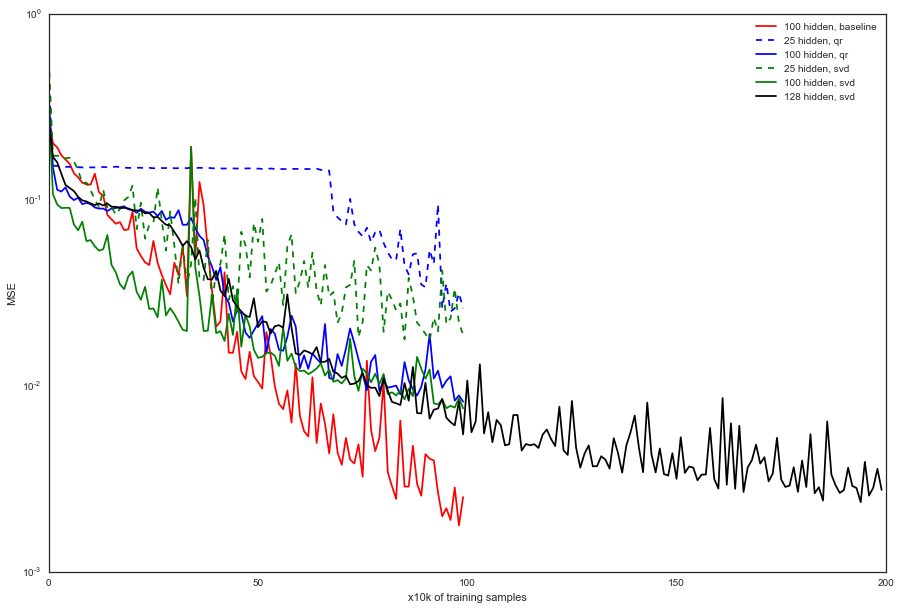

In [10]:
plt.figure(figsize=(15, 10))

rg = np.arange(len(hist_complex_100))

plt.plot(rg, hist_complex_100, 'r')
plt.plot(rg, hist_qr_25, 'b--')
plt.plot(rg, hist_qr_100, 'b')
plt.plot(rg, hist_svd_25, 'g--')
plt.plot(rg, hist_svd_100, 'g')
plt.plot(range(len(hist_qr_128)), hist_qr_128, 'k')
plt.axes().set_yscale('log')
plt.xlabel('x10k of training samples')
plt.ylabel('MSE')
plt.legend(['100 hidden, baseline', '25 hidden, qr', '100 hidden, qr', '25 hidden, svd', '100 hidden, svd', '128 hidden, svd'])
#plt.savefig('comparison_on_seq_length_55_new.png', dps=200)

In [ ]:
class MineCustomRecurrentLayer(MergeLayer):
    """
    lasagne.layers.recurrent.CustomRecurrentLayer(incoming, inTput_to_hidden,
    hidden_to_hidden, nonlinearity=lasagne.nonlinearities.rectify,
    hid_init=lasagne.init.Constant(0.), backwards=False,
    learn_init=False, gradient_steps=-1, grad_clipping=0,
    unroll_scan=False, precompute_input=True, mask_input=None,
    only_return_final=False, **kwargs)
    A layer which implements a recurrent connection.
    This layer allows you to specify custom input-to-hidden and
    hidden-to-hidden connections by instantiating :class:`lasagne.layers.Layer`
    instances and passing them on initialization.  Note that these connections
    can consist of multiple layers chained together.  The output shape for the
    provided input-to-hidden and hidden-to-hidden connections must be the same.
    If you are looking for a standard, densely-connected recurrent layer,
    please see :class:`RecurrentLayer`.  The output is computed by
    .. math ::
        h_t = \sigma(f_i(x_t) + f_h(h_{t-1}))
    Parameters
    ----------
    incoming : a :class:`lasagne.layers.Layer` instance or a tuple
        The layer feeding into this layer, or the expected input shape.
    input_to_hidden : :class:`lasagne.layers.Layer`
        :class:`lasagne.layers.Layer` instance which connects input to the
        hidden state (:math:`f_i`).  This layer may be connected to a chain of
        layers, which must end in a :class:`lasagne.layers.InputLayer` with the
        same input shape as `incoming`, except for the first dimension: When
        ``precompute_input == True`` (the default), it must be
        ``incoming.output_shape[0]*incoming.output_shape[1]`` or ``None``; when
        ``precompute_input == False``, it must be ``incoming.output_shape[0]``
        or ``None``.
    hidden_to_hidden : :class:`lasagne.layers.Layer`
        Layer which connects the previous hidden state to the new state
        (:math:`f_h`).  This layer may be connected to a chain of layers, which
        must end in a :class:`lasagne.layers.InputLayer` with the same input
        shape as `hidden_to_hidden`'s output shape.
    nonlinearity : callable or None
        Nonlinearity to apply when computing new state (:math:`\sigma`). If
        None is provided, no nonlinearity will be applied.
    hid_init : callable, np.ndarray, theano.shared or :class:`Layer`
        Initializer for initial hidden state (:math:`h_0`).
    backwards : bool
        If True, process the sequence backwards and then reverse the
        output again such that the output from the layer is always
        from :math:`x_1` to :math:`x_n`.
    learn_init : bool
        If True, initial hidden values are learned.
    gradient_steps : int
        Number of timesteps to include in the backpropagated gradient.
        If -1, backpropagate through the entire sequence.
    grad_clipping : float
        If nonzero, the gradient messages are clipped to the given value during
        the backward pass.  See [1]_ (p. 6) for further explanation.
    unroll_scan : bool
        If True the recursion is unrolled instead of using scan. For some
        graphs this gives a significant speed up but it might also consume
        more memory. When `unroll_scan` is True, backpropagation always
        includes the full sequence, so `gradient_steps` must be set to -1 and
        the input sequence length must be known at compile time (i.e., cannot
        be given as None).
    precompute_input : bool
        If True, precompute input_to_hid before iterating through
        the sequence. This can result in a speedup at the expense of
        an increase in memory usage.
    mask_input : :class:`lasagne.layers.Layer`
        Layer which allows for a sequence mask to be input, for when sequences
        are of variable length.  Default `None`, which means no mask will be
        supplied (i.e. all sequences are of the same length).
    only_return_final : bool
        If True, only return the final sequential output (e.g. for tasks where
        a single target value for the entire sequence is desired).  In this
        case, Theano makes an optimization which saves memory.
    Examples
    --------
    The following example constructs a simple `CustomRecurrentLayer` which
    has dense input-to-hidden and hidden-to-hidden connections.
    >>> import lasagne
    >>> n_batch, n_steps, n_in = (2, 3, 4)
    >>> n_hid = 5
    >>> l_in = lasagne.layers.InputLayer((n_batch, n_steps, n_in))
    >>> l_in_hid = lasagne.layers.DenseLayer(
    ...     lasagne.layers.InputLayer((None, n_in)), n_hid)
    >>> l_hid_hid = lasagne.layers.DenseLayer(
    ...     lasagne.layers.InputLayer((None, n_hid)), n_hid)
    >>> l_rec = lasagne.layers.CustomRecurrentLayer(l_in, l_in_hid, l_hid_hid)
    The CustomRecurrentLayer can also support "convolutional recurrence", as is
    demonstrated below.
    >>> n_batch, n_steps, n_channels, width, height = (2, 3, 4, 5, 6)
    >>> n_out_filters = 7
    >>> filter_shape = (3, 3)
    >>> l_in = lasagne.layers.InputLayer(
    ...     (n_batch, n_steps, n_channels, width, height))
    >>> l_in_to_hid = lasagne.layers.Conv2DLayer(
    ...     lasagne.layers.InputLayer((None, n_channels, width, height)),
    ...     n_out_filters, filter_shape, pad='same')
    >>> l_hid_to_hid = lasagne.layers.Conv2DLayer(
    ...     lasagne.layers.InputLayer(l_in_to_hid.output_shape),
    ...     n_out_filters, filter_shape, pad='same')
    >>> l_rec = lasagne.layers.CustomRecurrentLayer(
    ...     l_in, l_in_to_hid, l_hid_to_hid)
    References
    ----------
    .. [1] Graves, Alex: "Generating sequences with recurrent neural networks."
           arXiv preprint arXiv:1308.0850 (2013).
    """
    def __init__(self, incoming, input_to_hidden, hidden_to_hidden,
                 nonlinearity=nonlinearities.rectify,
                 hid_init=init.Constant(0.),
                 backwards=False,
                 learn_init=False,
                 gradient_steps=-1,
                 grad_clipping=0,
                 unroll_scan=False,
                 precompute_input=True,
                 mask_input=None,
                 only_return_final=False,
                 hidden_bias_init=init.Constant(0.),
                 **kwargs):

        # This layer inherits from a MergeLayer, because it can have three
        # inputs - the layer input, the mask and the initial hidden state.  We
        # will just provide the layer input as incomings, unless a mask input
        # or initial hidden state was provided.
        incomings = [incoming]
        self.mask_incoming_index = -1
        self.hid_init_incoming_index = -1
        if mask_input is not None:
            incomings.append(mask_input)
            self.mask_incoming_index = len(incomings)-1
        if isinstance(hid_init, Layer):
            incomings.append(hid_init)
            self.hid_init_incoming_index = len(incomings)-1

        super(MineCustomRecurrentLayer, self).__init__(incomings, **kwargs)

        self.input_to_hidden = input_to_hidden
        self.hidden_to_hidden = hidden_to_hidden
        self.learn_init = learn_init
        self.backwards = backwards
        self.gradient_steps = gradient_steps
        self.grad_clipping = grad_clipping
        self.unroll_scan = unroll_scan
        self.precompute_input = precompute_input
        self.only_return_final = only_return_final

        if unroll_scan and gradient_steps != -1:
            raise ValueError(
                "Gradient steps must be -1 when unroll_scan is true.")

        # Retrieve the dimensionality of the incoming layer
        input_shape = self.input_shapes[0]

        if unroll_scan and input_shape[1] is None:
            raise ValueError("Input sequence length cannot be specified as "
                             "None when unroll_scan is True")

        # Check that the input_to_hidden connection can appropriately handle
        # a first dimension of input_shape[0]*input_shape[1] when we will
        # precompute the input dot product
        if (self.precompute_input and
                input_to_hidden.output_shape[0] is not None and
                input_shape[0] is not None and
                input_shape[1] is not None and
                (input_to_hidden.output_shape[0] !=
                 input_shape[0]*input_shape[1])):
            raise ValueError(
                'When precompute_input == True, '
                'input_to_hidden.output_shape[0] must equal '
                'incoming.output_shape[0]*incoming.output_shape[1] '
                '(i.e. batch_size*sequence_length) or be None but '
                'input_to_hidden.output_shape[0] = {} and '
                'incoming.output_shape[0]*incoming.output_shape[1] = '
                '{}'.format(input_to_hidden.output_shape[0],
                            input_shape[0]*input_shape[1]))

        # Check that the first dimension of input_to_hidden and
        # hidden_to_hidden's outputs match when we won't precompute the input
        # dot product
        if (not self.precompute_input and
                input_to_hidden.output_shape[0] is not None and
                hidden_to_hidden.output_shape[0] is not None and
                (input_to_hidden.output_shape[0] !=
                 hidden_to_hidden.output_shape[0])):
            raise ValueError(
                'When precompute_input == False, '
                'input_to_hidden.output_shape[0] must equal '
                'hidden_to_hidden.output_shape[0] but '
                'input_to_hidden.output_shape[0] = {} and '
                'hidden_to_hidden.output_shape[0] = {}'.format(
                    input_to_hidden.output_shape[0],
                    hidden_to_hidden.output_shape[0]))

        # Check that input_to_hidden and hidden_to_hidden output shapes match,
        # but don't check a dimension if it's None for either shape
        if not all(s1 is None or s2 is None or s1 == s2
                   for s1, s2 in zip(input_to_hidden.output_shape[1:],
                                     hidden_to_hidden.output_shape[1:])):
            raise ValueError("The output shape for input_to_hidden and "
                             "hidden_to_hidden must be equal after the first "
                             "dimension, but input_to_hidden.output_shape={} "
                             "and hidden_to_hidden.output_shape={}".format(
                                 input_to_hidden.output_shape,
                                 hidden_to_hidden.output_shape))

        # Check that input_to_hidden's output shape is the same as
        # hidden_to_hidden's input shape but don't check a dimension if it's
        # None for either shape
        if not all(s1 is None or s2 is None or s1 == s2
                   for s1, s2 in zip(input_to_hidden.output_shape[1:],
                                     hidden_to_hidden.input_shape[1:])):
            raise ValueError("The output shape for input_to_hidden "
                             "must be equal to the input shape of "
                             "hidden_to_hidden after the first dimension, but "
                             "input_to_hidden.output_shape={} and "
                             "hidden_to_hidden.input_shape={}".format(
                                 input_to_hidden.output_shape,
                                 hidden_to_hidden.input_shape))

        if nonlinearity is None:
            self.nonlinearity = nonlinearities.identity
        else:
            self.nonlinearity = nonlinearity

        # Initialize hidden state
        if isinstance(hid_init, Layer):
            self.hid_init = hid_init
        else:
            self.hid_init = self.add_param(
                hid_init, (1,) + hidden_to_hidden.output_shape[1:],
                name="hid_init", trainable=learn_init, regularizable=False)

    def get_params(self, **tags):
        # Get all parameters from this layer, the master layer
        params = super(CustomRecurrentLayer, self).get_params(**tags)
        # Combine with all parameters from the child layers
        params += helper.get_all_params(self.input_to_hidden, **tags)
        params += helper.get_all_params(self.hidden_to_hidden, **tags)
        return params

    def get_output_shape_for(self, input_shapes):
        # The shape of the input to this layer will be the first element
        # of input_shapes, whether or not a mask input is being used.
        input_shape = input_shapes[0]
        # When only_return_final is true, the second (sequence step) dimension
        # will be flattened
        if self.only_return_final:
            return (input_shape[0],) + self.hidden_to_hidden.output_shape[1:]
        # Otherwise, the shape will be (n_batch, n_steps, trailing_dims...)
        else:
            return ((input_shape[0], input_shape[1]) +
                    self.hidden_to_hidden.output_shape[1:])

    def get_output_for(self, inputs, **kwargs):
        """
        Compute this layer's output function given a symbolic input variable.
        Parameters
        ----------
        inputs : list of theano.TensorType
            `inputs[0]` should always be the symbolic input variable.  When
            this layer has a mask input (i.e. was instantiated with
            `mask_input != None`, indicating that the lengths of sequences in
            each batch vary), `inputs` should have length 2, where `inputs[1]`
            is the `mask`.  The `mask` should be supplied as a Theano variable
            denoting whether each time step in each sequence in the batch is
            part of the sequence or not.  `mask` should be a matrix of shape
            ``(n_batch, n_time_steps)`` where ``mask[i, j] = 1`` when ``j <=
            (length of sequence i)`` and ``mask[i, j] = 0`` when ``j > (length
            of sequence i)``. When the hidden state of this layer is to be
            pre-filled (i.e. was set to a :class:`Layer` instance) `inputs`
            should have length at least 2, and `inputs[-1]` is the hidden state
            to prefill with.
        Returns
        -------
        layer_output : theano.TensorType
            Symbolic output variable.
        """
        # Retrieve the layer input
        input = inputs[0]
        # Retrieve the mask when it is supplied
        mask = None
        hid_init = None
        if self.mask_incoming_index > 0:
            mask = inputs[self.mask_incoming_index]
        if self.hid_init_incoming_index > 0:
            hid_init = inputs[self.hid_init_incoming_index]

        # Input should be provided as (n_batch, n_time_steps, n_features)
        # but scan requires the iterable dimension to be first
        # So, we need to dimshuffle to (n_time_steps, n_batch, n_features)
        input = input.dimshuffle(1, 0, *range(2, input.ndim))
        seq_len, num_batch = input.shape[0], input.shape[1]

        if self.precompute_input:
            # Because the input is given for all time steps, we can precompute
            # the inputs to hidden before scanning. First we need to reshape
            # from (seq_len, batch_size, trailing dimensions...) to
            # (seq_len*batch_size, trailing dimensions...)
            # This strange use of a generator in a tuple was because
            # input.shape[2:] was raising a Theano error
            trailing_dims = tuple(input.shape[n] for n in range(2, input.ndim))
            input = T.reshape(input, (seq_len*num_batch,) + trailing_dims)
            input = helper.get_output(
                self.input_to_hidden, input, **kwargs)

            # Reshape back to (seq_len, batch_size, trailing dimensions...)
            trailing_dims = tuple(input.shape[n] for n in range(1, input.ndim))
            input = T.reshape(input, (seq_len, num_batch) + trailing_dims)

        # We will always pass the hidden-to-hidden layer params to step
        non_seqs = helper.get_all_params(self.hidden_to_hidden)
        # When we are not precomputing the input, we also need to pass the
        # input-to-hidden parameters to step
        if not self.precompute_input:
            non_seqs += helper.get_all_params(self.input_to_hidden)

        # Create single recurrent computation step function
        def step(input_n, hid_previous, *args):
            # Compute the hidden-to-hidden activation
            hid_pre = helper.get_output(
                self.hidden_to_hidden, hid_previous, **kwargs)

            # If the dot product is precomputed then add it, otherwise
            # calculate the input_to_hidden values and add them
            if self.precompute_input:
                hid_pre += input_n
            else:
                hid_pre += helper.get_output(
                    self.input_to_hidden, input_n, **kwargs)

            # Clip gradients
            if self.grad_clipping:
                hid_pre = theano.gradient.grad_clip(
                    hid_pre, -self.grad_clipping, self.grad_clipping)

            return self.nonlinearity(hid_pre)

        def step_masked(input_n, mask_n, hid_previous, *args):
            # Skip over any input with mask 0 by copying the previous
            # hidden state; proceed normally for any input with mask 1.
            hid = step(input_n, hid_previous, *args)
            hid_out = T.switch(mask_n, hid, hid_previous)
            return [hid_out]

        if mask is not None:
            mask = mask.dimshuffle(1, 0, 'x')
            sequences = [input, mask]
            step_fun = step_masked
        else:
            sequences = input
            step_fun = step

        if not isinstance(self.hid_init, Layer):
            # The code below simply repeats self.hid_init num_batch times in
            # its first dimension.  Turns out using a dot product and a
            # dimshuffle is faster than T.repeat.
            dot_dims = (list(range(1, self.hid_init.ndim - 1)) +
                        [0, self.hid_init.ndim - 1])
            hid_init = T.dot(T.ones((num_batch, 1)),
                             self.hid_init.dimshuffle(dot_dims))

        if self.unroll_scan:
            # Retrieve the dimensionality of the incoming layer
            input_shape = self.input_shapes[0]
            # Explicitly unroll the recurrence instead of using scan
            hid_out = unroll_scan(
                fn=step_fun,
                sequences=sequences,
                outputs_info=[hid_init],
                go_backwards=self.backwards,
                non_sequences=non_seqs,
                n_steps=input_shape[1])[0]
        else:
            # Scan op iterates over first dimension of input and repeatedly
            # applies the step function
            hid_out = theano.scan(
                fn=step_fun,
                sequences=sequences,
                go_backwards=self.backwards,
                outputs_info=[hid_init],
                non_sequences=non_seqs,
                truncate_gradient=self.gradient_steps,
                strict=True)[0]

        # When it is requested that we only return the final sequence step,
        # we need to slice it out immediately after scan is applied
        if self.only_return_final:
            hid_out = hid_out[-1]
        else:
            # dimshuffle back to (n_batch, n_time_steps, n_features))
            hid_out = hid_out.dimshuffle(1, 0, *range(2, hid_out.ndim))

            # if scan is backward reverse the output
            if self.backwards:
                hid_out = hid_out[:, ::-1]

        return hid_out

In [ ]:
x = rnd.randn(5, 5) + 1j * rnd.randn(5,5)

In [ ]:
u, s, v = la.svd(x, full_matrices=False)

In [ ]:
q, r = la.qr(x)

In [ ]:
Q = u @ np.eye(s.size) @ v

In [ ]:
la.norm(Q - q) / la.norm(q)

In [39]:
la.norm(np.stack([np.ones((3, 4, 5)), np.ones((3, 4, 5))*10], 0), axis=0)

array([[[ 10.04987562,  10.04987562,  10.04987562,  10.04987562,  10.04987562],
        [ 10.04987562,  10.04987562,  10.04987562,  10.04987562,  10.04987562],
        [ 10.04987562,  10.04987562,  10.04987562,  10.04987562,  10.04987562],
        [ 10.04987562,  10.04987562,  10.04987562,  10.04987562,  10.04987562]],

       [[ 10.04987562,  10.04987562,  10.04987562,  10.04987562,  10.04987562],
        [ 10.04987562,  10.04987562,  10.04987562,  10.04987562,  10.04987562],
        [ 10.04987562,  10.04987562,  10.04987562,  10.04987562,  10.04987562],
        [ 10.04987562,  10.04987562,  10.04987562,  10.04987562,  10.04987562]],

       [[ 10.04987562,  10.04987562,  10.04987562,  10.04987562,  10.04987562],
        [ 10.04987562,  10.04987562,  10.04987562,  10.04987562,  10.04987562],
        [ 10.04987562,  10.04987562,  10.04987562,  10.04987562,  10.04987562],
        [ 10.04987562,  10.04987562,  10.04987562,  10.04987562,  10.04987562]]])